# Mouse Aging clustering analysis and annotation 

The Mouse Aging dataset [Jin et al] is a comprehensive single-cell RNA sequencing (scRNA-seq) dataset containing ~1.2 million high-quality single-cell transcriptomes of brain cells from young adult and aged mice of both sexes, from regions spanning the forebrain, midbrain, and hindbrain. High-resolution de novo clustering of all cells results in 847 cell clusters and reveals at least 14 age-biased clusters that are mostly glial types. Clusters in the study were mapped to the whole mouse brain taxonomy (WMB-taxonomy, [Yao et al.](https://www.biorxiv.org/content/10.1101/2023.03.06.531121v1)) to provide class, subclass and supertype annotations. At the broader cell subclass and supertype levels, age-associated gene expression signatures were analyzed resulting in a list of 2,449 differentially expressed genes (age-DE genes) for many neuronal and non-neuronal cell types. 

The purpose of this set of notebooks is to provide an overview of the data, the file organization, and how to combine data and metadata through example use cases.

You need to be connected to the internet to run this notebook or connected to a cache that has the Aging Mouse data downloaded already. Make sure to have run the `getting_started` notebook as well if you haven't already done so and familiarized yourself with the cache object.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the ``general_acessing_10x_snRNASeq_tutorial.ipynb`` tutorial/example. 

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the AbcProjectCache. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas Dataframe. See the [`getting_started`](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been.  

Change the download_base variable to where you have downloaded the data in your system. 

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20241130/manifest.json'

## Data overview  

### Cell metadata  

Essential cell metadata is stored as a DataFrame. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database.  

Each cell is associated with a *library label*, *library method*, *donor label*, *donor sex*, dissection *region_of_interest_label*, the corresponding coarse *anatomical division label* and the *matrix_prefix* identifying which data package this cell is part of.  

Further, each cell is associated with a *cluster alias* representing which cluster this cell is a member of and (x, y) coordinates of the cells in the UMAP. 

Below, we load the first of the metadata used in this tutorial. This pattern of loading metadata is repeated throughout the tutorials. 

In [3]:
abc_cache.list_metadata_files('Zeng-Aging-Mouse-10Xv3')

['cell_annotation_colors',
 'cell_cluster_annotations',
 'cell_metadata',
 'cluster',
 'donor',
 'example_genes_all_cells_expression',
 'library',
 'value_sets']

In [4]:
abc_cache.list_metadata_files('Zeng-Aging-Mouse-WMB-taxonomy')

['aging_degenes',
 'cell_cluster_mapping_annotations',
 'cell_cross_mapping_annotations',
 'cluster_mapping',
 'cluster_mapping_pivot']

In [5]:
cell = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_metadata',
    dtype={'cell_label': str,
           'wmb_cluster_alias': 'Int64'}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head()

Number of cells =  1162565


cell_barcode  gene_count  umi_count  \
cell_label                                                          
AAACCCAAGGACACTG-367_B04  AAACCCAAGGACACTG        6176    26113.0   
AAACCCAAGTAAACGT-367_B04  AAACCCAAGTAAACGT        3717    10926.0   
AAACCCACATTGAGCT-367_B04  AAACCCACATTGAGCT        1358     2054.0   
AAACGAAAGCCGTAAG-367_B04  AAACGAAAGCCGTAAG        3103     6899.0   
AAACGAAAGCTACAAA-367_B04  AAACGAAAGCTACAAA        4459    16420.0   

                          doublet_score          x          y  cluster_alias  \
cell_label                                                                     
AAACCCAAGGACACTG-367_B04           0.09  -2.288070   3.757430            273   
AAACCCAAGTAAACGT-367_B04           0.05   1.104098  11.232103            787   
AAACCCACATTGAGCT-367_B04           0.02  -2.465144  17.637245            833   
AAACGAAAGCCGTAAG-367_B04           0.03   1.328812  10.103676            787   
AAACGAAAGCTACAAA-367_B04           0.09  16.493496   2.265491            815   

                          cell_in_wmb_study  wmb_cluster_alias  \
cell_label                                                       
AAACCCAAGGACACTG-367_B04               True               1067   
AAACCCAAGTAAACGT-367_B04               True              14939   
AAACCCACATTGAGCT-367_B04               True               5255   
AAACGAAAGCCGTAAG-367_B04               True              14947   
AAACGAAAGCTACAAA-367_B04               True               5230   

                               library_label  ...  \
cell_label                                    ...   
AAACCCAAGGACACTG-367_B04  L8TX_200924_01_G05  ...   
AAACCCAAGTAAACGT-367_B04  L8TX_200924_01_G05  ...   
AAACCCACATTGAGCT-367_B04  L8TX_200924_01_G05  ...   
AAACGAAAGCCGTAAG-367_B04  L8TX_200924_01_G05  ...   
AAACGAAAGCTACAAA-367_B04  L8TX_200924_01_G05  ...   

                                           donor_label population_sampling  \
cell_label                                                                   
AAACCCAAGGACACTG-367_B04  Snap25-IRES2-Cre;Ai14-544400            unbiased   
AAACCCAAGTAAACGT-367_B04  Snap25-IRES2-Cre;Ai14-544400            unbiased   
AAACCCACATTGAGCT-367_B04  Snap25-IRES2-Cre;Ai14-544400            unbiased   
AAACGAAAGCCGTAAG-367_B04  Snap25-IRES2-Cre;Ai14-544400            unbiased   
AAACGAAAGCTACAAA-367_B04  Snap25-IRES2-Cre;Ai14-544400            unbiased   

                                                donor_genotype donor_sex  \
cell_label                                                                 
AAACCCAAGGACACTG-367_B04  Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt         F   
AAACCCAAGTAAACGT-367_B04  Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt         F   
AAACCCACATTGAGCT-367_B04  Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt         F   
AAACGAAAGCCGTAAG-367_B04  Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt         F   
AAACGAAAGCTACAAA-367_B04  Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt         F   

                         donor_age donor_age_category  donor_in_wmb_study  \
cell_label                                                                  
AAACCCAAGGACACTG-367_B04       P58              adult                True   
AAACCCAAGTAAACGT-367_B04       P58              adult                True   
AAACCCACATTGAGCT-367_B04       P58              adult                True   
AAACGAAAGCCGTAAG-367_B04       P58              adult                True   
AAACGAAAGCTACAAA-367_B04       P58              adult                True   

                            feature_matrix_label           dataset_label  \
cell_label                                                                 
AAACCCAAGGACACTG-367_B04  Zeng-Aging-Mouse-10Xv3  Zeng-Aging-Mouse-10Xv3   
AAACCCAAGTAAACGT-367_B04  Zeng-Aging-Mouse-10Xv3  Zeng-Aging-Mouse-10Xv3   
AAACCCACATTGAGCT-367_B04  Zeng-Aging-Mouse-10Xv3  Zeng-Aging-Mouse-10Xv3   
AAACGAAAGCCGTAAG-367_B04  Zeng-Aging-Mouse-10Xv3  Zeng-Aging-Mouse-10Xv3   
AAACGAAAGCTACAAA-367_B04  Zeng-Aging-Mouse-10Xv3  Zeng-Aging-Mouse-10Xv3  

We can use pandas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [6]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [7]:
print_column_info(cell)

Number of unique cell_barcode = 997258 
Number of unique gene_count = 9838 
Number of unique umi_count = 81632 
Number of unique doublet_score = 874 
Number of unique x = 1146862 
Number of unique y = 1146950 
Number of unique cluster_alias = 847 
Number of unique cell_in_wmb_study = 2 [False, True]
Number of unique wmb_cluster_alias = 2656 
Number of unique library_label = 287 
Number of unique alignment_job_id = 287 
Number of unique library_method = 2 ['10Xv3', '10xV3.1']
Number of unique barcoded_cell_sample_label = 287 
Number of unique enrichment_population = 6 ['Calcein-positive, Hoechst-positive', 'Hoechst-positive', 'No FACS', 'RFP-positive, Calcein-positive, Hoechst-positive', 'RFP-positive, DAPI-negative', 'RFP-positive, Hoechst-positive']
Number of unique region_of_interest_label = 16 ['HPF - ENT', 'HPF - HIP', 'HPF - PAR-POST-PRE-SUB-ProS', 'HY - HY', 'Iscortex  - ACA', 'Isocortex  - AI', 'Isocortex - PL-ILA-ORB', 'Isocortex - RSP', 'MB - PAG-RAmb', 'MB - VTA-SN', 'P - Pmo

#### Cell metadata colors 

Below we load a DataFrame containing name and color mappings pre-cell for donor sex, region of interest, and anatomical division. This DataFrame is indexed by cell the same as the above cell_metadata. This allows us to label the UMAP with the previously mentioned distinct labels. 

In [8]:
cell_colors = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cell_annotation_colors'
).set_index('cell_label')
cell_colors.head()

anatomical_division_color  anatomical_division_order  \
cell_label                                                                      
AAACCCAAGGACACTG-367_B04                   #98D6F9                          2   
AAACCCAAGTAAACGT-367_B04                   #98D6F9                          2   
AAACCCACATTGAGCT-367_B04                   #98D6F9                          2   
AAACGAAAGCCGTAAG-367_B04                   #98D6F9                          2   
AAACGAAAGCTACAAA-367_B04                   #98D6F9                          2   

                         donor_age_category_color  donor_age_category_order  \
cell_label                                                                    
AAACCCAAGGACACTG-367_B04                  #9ACA3C                         0   
AAACCCAAGTAAACGT-367_B04                  #9ACA3C                         0   
AAACCCACATTGAGCT-367_B04                  #9ACA3C                         0   
AAACGAAAGCCGTAAG-367_B04                  #9ACA3C                         0   
AAACGAAAGCTACAAA-367_B04                  #9ACA3C                         0   

                         donor_sex_color  donor_sex_order  \
cell_label                                                  
AAACCCAAGGACACTG-367_B04         #FAAA5B                0   
AAACCCAAGTAAACGT-367_B04         #FAAA5B                0   
AAACCCACATTGAGCT-367_B04         #FAAA5B                0   
AAACGAAAGCCGTAAG-367_B04         #FAAA5B                0   
AAACGAAAGCTACAAA-367_B04         #FAAA5B                0   

                         region_of_interest_color  region_of_interest_order  
cell_label                                                                   
AAACCCAAGGACACTG-367_B04                  #98D6F9                         7  
AAACCCAAGTAAACGT-367_B04                  #98D6F9                         7  
AAACCCACATTGAGCT-367_B04                  #98D6F9                         7  
AAACGAAAGCCGTAAG-367_B04                  #98D6F9                         7  
AAACGAAAGCTACAAA-367_B04                  #98D6F9                         7

We will merge these two DataFrames to create one that contains both cell metadata and color information, ready to plot on a UMAP. We also shuffle the cell metadata to get a more representative plot in the UMAP. This is done as the default DataFrame is sorted cell_id which correlates with some of the metadata (e.g. age). 

In [9]:
cell_extended = cell.join(cell_colors, rsuffix='_cl_colors')
cell_extended = cell_extended.sample(frac=1, random_state=12345)
cell_extended.head()

cell_barcode  gene_count  umi_count  \
cell_label                                                          
GCCTGTTGTGAATTAG-135_B01  GCCTGTTGTGAATTAG        6777    37834.0   
TCCGAAAGTGAAGCGT-761_A04  TCCGAAAGTGAAGCGT        3396     9585.0   
TTACCATGTCGTGGTC-327_A06  TTACCATGTCGTGGTC        4294    10527.0   
ACGGGTCGTACGAGCA-385_D06  ACGGGTCGTACGAGCA        2943     6957.0   
CTTAGGATCTGTCCCA-301_B04  CTTAGGATCTGTCCCA        7907    47406.0   

                          doublet_score          x          y  cluster_alias  \
cell_label                                                                     
GCCTGTTGTGAATTAG-135_B01       0.200000  -1.185296   1.881103            278   
TCCGAAAGTGAAGCGT-761_A04       0.030303  14.007499  -0.220336            817   
TTACCATGTCGTGGTC-327_A06       0.020000   6.550781  -1.378886            804   
ACGGGTCGTACGAGCA-385_D06       0.000000  13.650183   0.289086            817   
CTTAGGATCTGTCCCA-301_B04       0.037037   6.583878 -10.639808            152   

                          cell_in_wmb_study  wmb_cluster_alias  \
cell_label                                                       
GCCTGTTGTGAATTAG-135_B01               True               1079   
TCCGAAAGTGAAGCGT-761_A04              False               <NA>   
TTACCATGTCGTGGTC-327_A06              False               <NA>   
ACGGGTCGTACGAGCA-385_D06              False               <NA>   
CTTAGGATCTGTCCCA-301_B04              False               <NA>   

                               library_label  ...           dataset_label  \
cell_label                                    ...                           
GCCTGTTGTGAATTAG-135_B01  L8TX_190716_01_D07  ...  Zeng-Aging-Mouse-10Xv3   
TCCGAAAGTGAAGCGT-761_A04  L8TX_210805_01_H01  ...  Zeng-Aging-Mouse-10Xv3   
TTACCATGTCGTGGTC-327_A06  L8TX_200813_01_H10  ...  Zeng-Aging-Mouse-10Xv3   
ACGGGTCGTACGAGCA-385_D06  L8TX_201008_01_A12  ...  Zeng-Aging-Mouse-10Xv3   
CTTAGGATCTGTCCCA-301_B04  L8TX_200723_01_B10  ...  Zeng-Aging-Mouse-10Xv3   

                                                 abc_sample_id  \
cell_label                                                       
GCCTGTTGTGAATTAG-135_B01  b801b060-42b7-465c-a768-1a9b8dd9de7f   
TCCGAAAGTGAAGCGT-761_A04  a59a8bc8-3c52-4d77-bebf-4ebf31e8d079   
TTACCATGTCGTGGTC-327_A06  2e5da533-b920-4707-aba1-d27f04ce5018   
ACGGGTCGTACGAGCA-385_D06  8b63cdce-4d15-4e88-b154-c29fd0e23ff1   
CTTAGGATCTGTCCCA-301_B04  8c290798-5c6e-42d9-a906-bfb69ec4399b   

                         anatomical_division_color anatomical_division_order  \
cell_label                                                                     
GCCTGTTGTGAATTAG-135_B01                   #98D6F9                         2   
TCCGAAAGTGAAGCGT-761_A04                   #7ED04B                         1   
TTACCATGTCGTGGTC-327_A06                   #8599CC                         3   
ACGGGTCGTACGAGCA-385_D06                   #E64438                         4   
CTTAGGATCTGTCCCA-301_B04                   #7ED04B                         1   

                         donor_age_category_color donor_age_category_order  \
cell_label                                                                   
GCCTGTTGTGAATTAG-135_B01                  #9ACA3C                        0   
TCCGAAAGTGAAGCGT-761_A04                  #CC6828                        1   
TTACCATGTCGTGGTC-327_A06                  #CC6828                        1   
ACGGGTCGTACGAGCA-385_D06                  #CC6828                        1   
CTTAGGATCTGTCCCA-301_B04                  #CC6828                        1   

                          donor_sex_color donor_sex_order  \
cell_label                                                  
GCCTGTTGTGAATTAG-135_B01          #FAAA5B               0   
TCCGAAAGTGAAGCGT-761_A04          #FAAA5B               0   
TTACCATGTCGTGGTC-327_A06          #735AA6               1   
ACGGGTCGTACGAGCA-385_D06          #735AA6               1   
CTTAGGATCTGTCCCA-301_B04          #FAAA5B    

### UMAP spatial embedding: Donor and anatomic information  

Now that we've merged the color information into the main cells data, we can plot the Uniform Manifold Approximation and Projection (UMAP) for all the cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. The x and y columns of the cell metadata table represent the coordinate of all cells in the UMAP in Figure 1 of the manuscript.  

We define a small helper function *plot umap* to visualize the cells on the UMAP. In this example will plot associated cell information colorized by dissection region of interest, neurotransmitter identity, sex, taxonomy level, age category, and age depletion/enrichment. 

In [10]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None, labels=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.')

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_colors = cc.unique()
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, labels, loc=0)
        # ax.add_artist(legend)

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

Below we plot the UMAPS for each of anatomical division, dissection, sex, and age. 

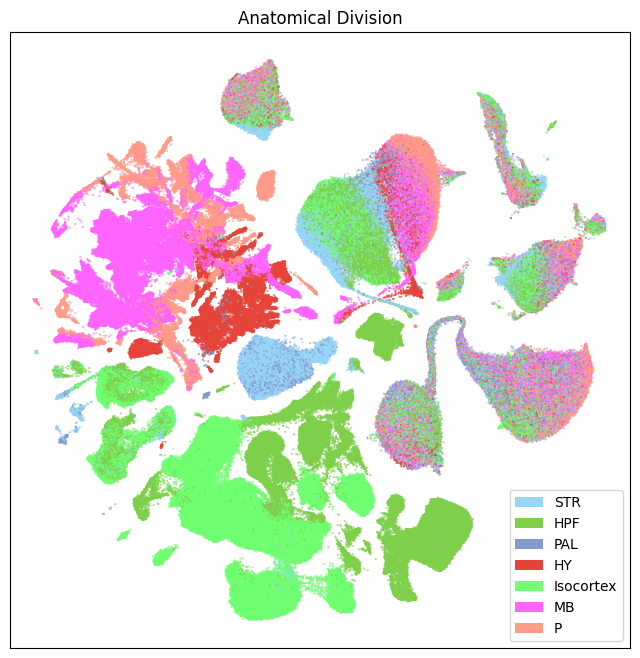

In [11]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['anatomical_division_color'],
    labels=cell_extended['anatomical_division_label'].unique()
)
res = ax.set_title("Anatomical Division")
plt.show()

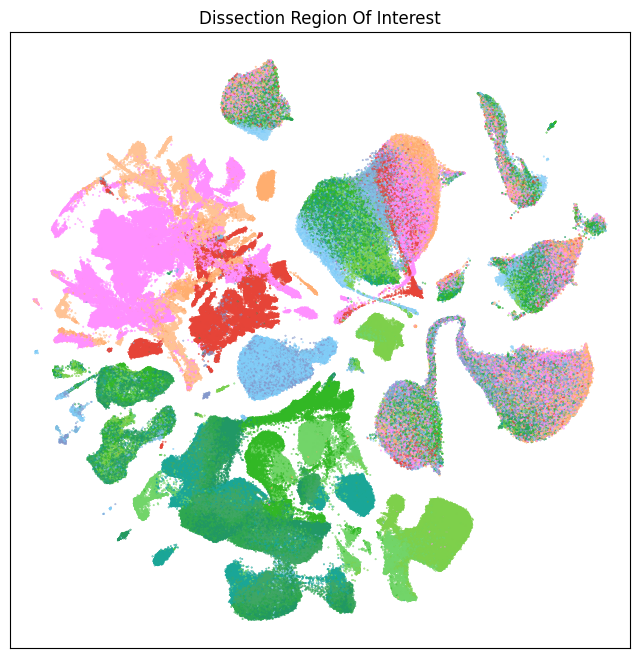

In [12]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['region_of_interest_color']
)
res = ax.set_title("Dissection Region Of Interest")
plt.show()

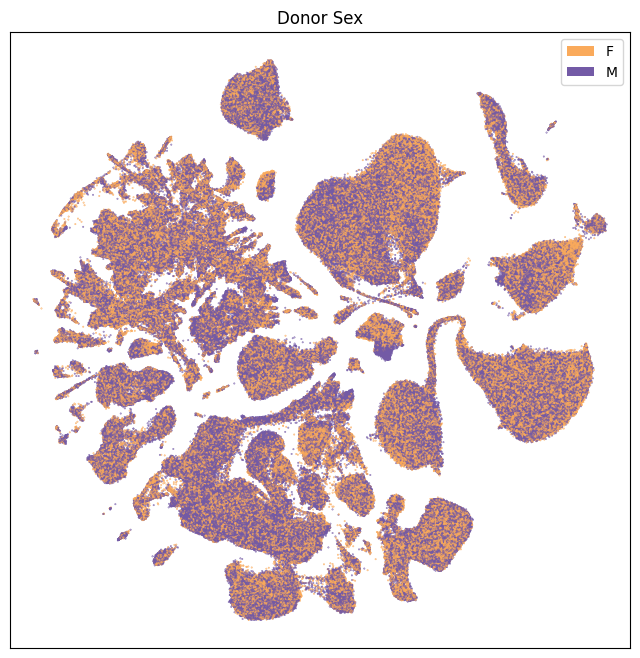

In [13]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_sex_color'],
    labels=cell_extended['donor_sex'].unique()
)
res = ax.set_title("Donor Sex")
plt.show()

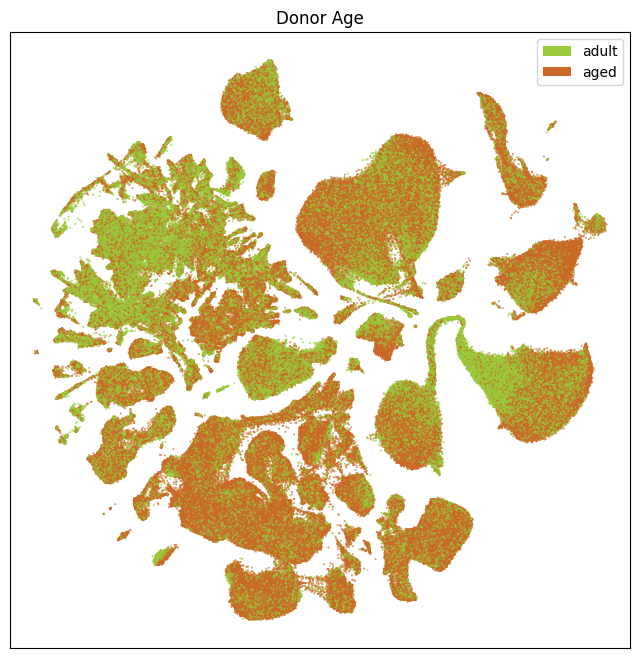

In [14]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_age_category_color'],
    labels=cell_extended['donor_age_category'].unique()
)
res = ax.set_title("Donor Age")
plt.show()

##  Cluster Metadata

We load information on the individual clusters including the age ratio, odds, and neurotransmitter information. This metadata is indexed on cluster_alias which is also a column in the cell_metadata that allows us to merge the information into that DataFrame. 

In [15]:
cluster_info = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-10Xv3',
    file_name='cluster'
).set_index('cluster_alias')
cluster_info.head()

number_of_cells    cluster_label  cluster_order  \
cluster_alias                                                    
1                          851  CS20241021_0001              0   
2                          330  CS20241021_0002              1   
3                          589  CS20241021_0003              2   
4                          207  CS20241021_0004              3   
5                         2141  CS20241021_0005              4   

                            cluster_name cluster_color  \
cluster_alias                                            
1              1_CLA-EPd-CTX Car3 Glut_1       #f7c27a   
2                     2_IT EP-CLA Glut_1       #5c1a34   
3                     3_IT EP-CLA Glut_1       #b96cf0   
4                     4_IT EP-CLA Glut_1       #bff691   
5                     5_IT EP-CLA Glut_1       #39fbfa   

              max_region_of_interest_label  \
cluster_alias                                
1                          Isocortex  - AI   
2                          Isocortex  - AI   
3                          Isocortex  - AI   
4                          Isocortex  - AI   
5                          Isocortex  - AI   

               proportion_max_region_of_interest_label  number_of_adult_cells  \
cluster_alias                                                                   
1                                             0.831962                    183   
2                                             0.969697                    160   
3                                             0.894737                    240   
4                                             0.971014                    107   
5                                             0.987389                    655   

               number_of_aged_cells  proportion_adult_cells  \
cluster_alias                                                 
1                               668                0.215041   
2                               170                0.484848   
3                               349                0.407470   
4                               100                0.516908   
5                              1486                0.305932   

               proportion_aged_cells  odds_ratio  log2_odds_ratio  \
cluster_alias                                                       
1                           0.784959    1.453797         0.539826   
2                           0.515152    0.421595        -1.246071   
3                           0.592530    0.576896        -0.793616   
4                           0.483092    0.371035        -1.430373   
5                           0.694068    0.900735        -0.150825   

              cluster_age_bias max_region_of_interest_color  \
cluster_alias                                                 
1                   unassigned                      #219866   
2                   unassigned                      #219866   
3                   unassigned                      #219866   
4                   unassigned                      #219866   
5                   unassigned                      #219866   

              cluster_age_bias_color neurotransmitter_combined_label  \
cluster_alias                                                          
1                            #DADEDF                            Glut   
2                            #DADEDF                            Glut   
3                            #DADEDF                            Glut   
4                            #DADEDF                            Glut   
5                            #DADEDF                            Glut   

              neurotransmitter_label neurotransmitter_color  
cluster_alias                                                
1                               Glut                #2B93DF  
2                               Glut                #2B93DF  
3                               Glut                #2B93DF  
4                               Glut                #2B93DF  
5        

Now that we have our data loaded and indexed, we can merge the tables together to create a single DataFrame allowing us to plot various information onto the UMAP and beyond. 

In [16]:
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell_extended.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')
cell_extended.head()

cell_barcode  gene_count  umi_count  \
cell_label                                                          
GCCTGTTGTGAATTAG-135_B01  GCCTGTTGTGAATTAG        6777    37834.0   
TCCGAAAGTGAAGCGT-761_A04  TCCGAAAGTGAAGCGT        3396     9585.0   
TTACCATGTCGTGGTC-327_A06  TTACCATGTCGTGGTC        4294    10527.0   
ACGGGTCGTACGAGCA-385_D06  ACGGGTCGTACGAGCA        2943     6957.0   
CTTAGGATCTGTCCCA-301_B04  CTTAGGATCTGTCCCA        7907    47406.0   

                          doublet_score          x          y  cluster_alias  \
cell_label                                                                     
GCCTGTTGTGAATTAG-135_B01       0.200000  -1.185296   1.881103            278   
TCCGAAAGTGAAGCGT-761_A04       0.030303  14.007499  -0.220336            817   
TTACCATGTCGTGGTC-327_A06       0.020000   6.550781  -1.378886            804   
ACGGGTCGTACGAGCA-385_D06       0.000000  13.650183   0.289086            817   
CTTAGGATCTGTCCCA-301_B04       0.037037   6.583878 -10.639808            152   

                          cell_in_wmb_study  wmb_cluster_alias  \
cell_label                                                       
GCCTGTTGTGAATTAG-135_B01               True               1079   
TCCGAAAGTGAAGCGT-761_A04              False               <NA>   
TTACCATGTCGTGGTC-327_A06              False               <NA>   
ACGGGTCGTACGAGCA-385_D06              False               <NA>   
CTTAGGATCTGTCCCA-301_B04              False               <NA>   

                               library_label  ...  proportion_adult_cells  \
cell_label                                    ...                           
GCCTGTTGTGAATTAG-135_B01  L8TX_190716_01_D07  ...                0.577949   
TCCGAAAGTGAAGCGT-761_A04  L8TX_210805_01_H01  ...                0.454494   
TTACCATGTCGTGGTC-327_A06  L8TX_200813_01_H10  ...                0.370570   
ACGGGTCGTACGAGCA-385_D06  L8TX_201008_01_A12  ...                0.454494   
CTTAGGATCTGTCCCA-301_B04  L8TX_200723_01_B10  ...                0.403409   

                         proportion_aged_cells odds_ratio log2_odds_ratio  \
cell_label                                                                  
GCCTGTTGTGAATTAG-135_B01              0.422051   1.013716        0.019653   
TCCGAAAGTGAAGCGT-761_A04              0.545506   1.046448        0.065500   
TTACCATGTCGTGGTC-327_A06              0.629430   1.741208        0.800089   
ACGGGTCGTACGAGCA-385_D06              0.545506   1.046448        0.065500   
CTTAGGATCTGTCCCA-301_B04              0.596591   0.587232       -0.767999   

                         cluster_age_bias max_region_of_interest_color  \
cell_label                                                               
GCCTGTTGTGAATTAG-135_B01       unassigned                      #80CDF8   
TCCGAAAGTGAAGCGT-761_A04       unassigned                      #8599CC   
TTACCATGTCGTGGTC-327_A06       unassigned                      #80C0E2   
ACGGGTCGTACGAGCA-385_D06       unassigned                      #8599CC   
CTTAGGATCTGTCCCA-301_B04       unassigned                      #72D569   

                          cluster_age_bias_color  \
cell_label                                         
GCCTGTTGTGAATTAG-135_B01                 #DADEDF   
TCCGAAAGTGAAGCGT-761_A04                 #DADEDF   
TTACCATGTCGTGGTC-327_A06                 #DADEDF   
ACGGGTCGTACGAGCA-385_D06                 #DADEDF   
CTTAGGATCTGTCCCA-301_B04                 #DADEDF   

                         neurotransmitter_combined_label  \
cell_label                                                 
GCCTGTTGTGAATTAG-135_B01                            GABA   
TCCGAAAGTGAAGCGT-761_A04                           No-NT   
TTACCATGTCGTGGTC-327_A06                           No-NT   
ACGGGTCGTACGAGCA-385_D06                           No-NT   
CTTAGGATCTGTCCCA-301_B04                            Glut   

                         neurotransmitter_label neurotransmitter_color  
cell_label                                                      

### UMAP: Taxonomy information

Below are UMAPs for labels associated with the taxonomy, namely: neurotransmitter and cluster. Note that the colors for neurotransmitter (and for class, subclass, and supertype) are the same as those from the WMB taxonomy.

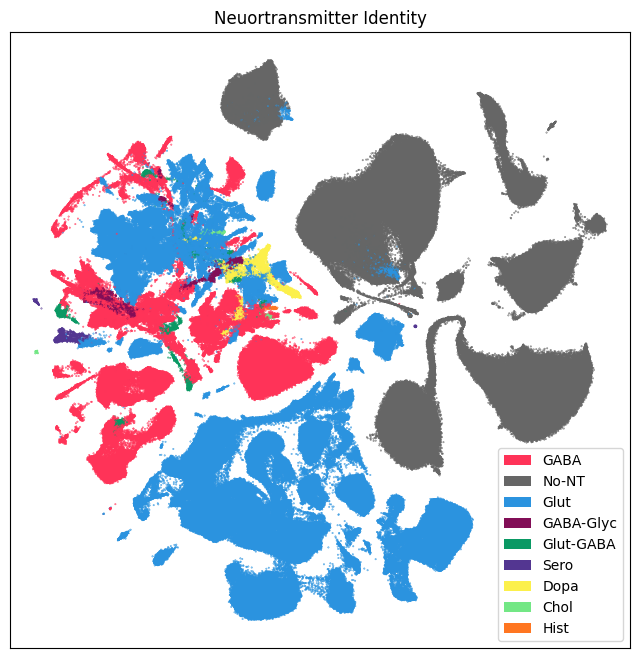

In [17]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['neurotransmitter_color'],
    labels=cell_extended['neurotransmitter_label'].unique()
)
res = ax.set_title("Neuortransmitter Identity")
plt.show()

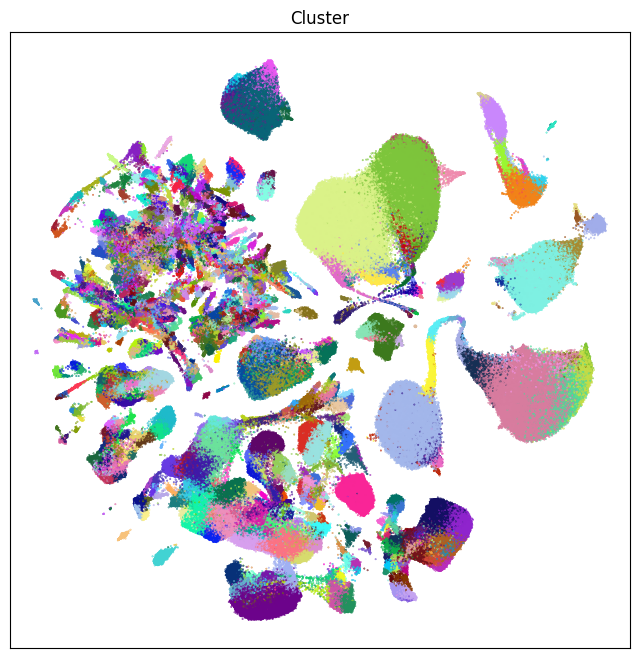

In [18]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['cluster_color'])
res = ax.set_title("Cluster")
plt.show()

#### Aging information 

We plot aging related information on our UMAP, showing the different age-related variables and they are expressed in different locations of the UMAP. Below we show the location of the cells from the adult and aged mice. 

Next, we show the log of the cluster level odds ratio for a given cluster to be age enriched (brown) or depleted (blue-green). 

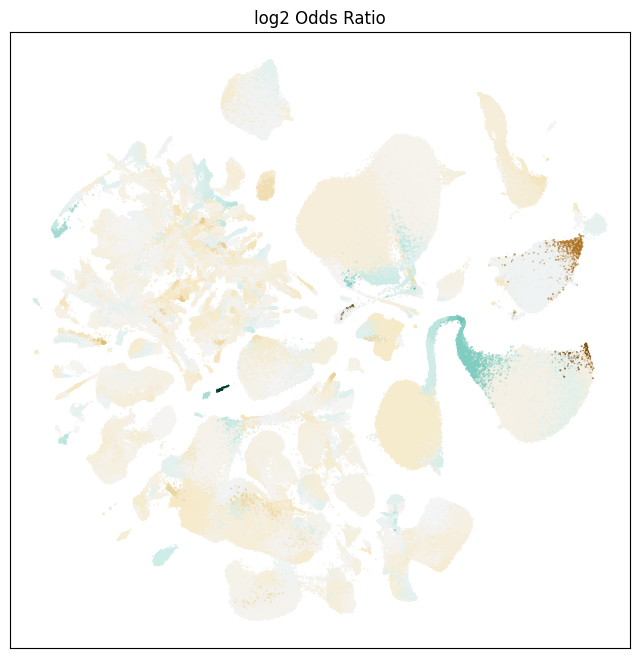

In [19]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    val=cell_extended['log2_odds_ratio'],
    cmap='BrBG_r'
)
res = ax.set_title("log2 Odds Ratio")
plt.show()

Finally, we show the clusters that are identified as aging-enriched and aging-depleted based on their odds ratio. (-2.5 > log2_odds_ratio, log2_odds_ratio > 2.5). 

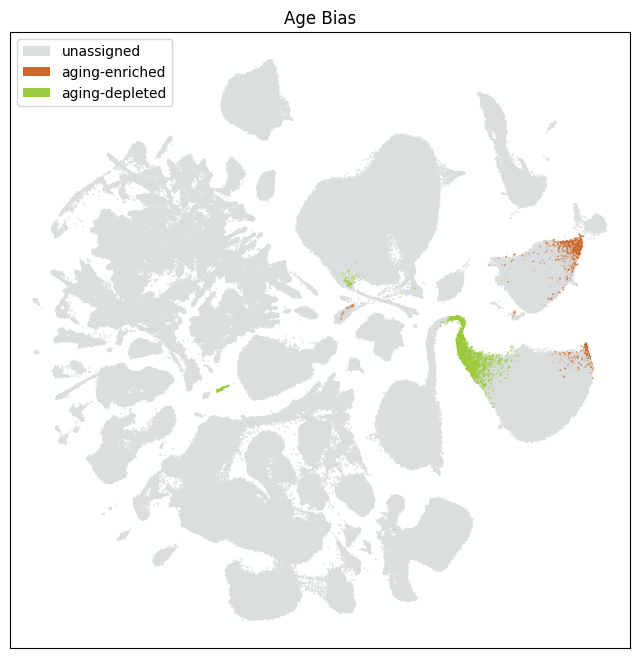

In [20]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['cluster_age_bias_color'],
    labels=cell_extended['cluster_age_bias'].unique()
)
res = ax.set_title("Age Bias")
plt.show()

## Taxonomy Mapping

The following metadata maps all cells to the clusters and above levels in the taxonomy hierarchy. This includes all names and colors for each part of the taxonomy. As show in the above cluster tutorial for this dataset, each cluster in the Aging Dataset is nested within a supertype from the WMB dataset allowing one to walk all the way up to the class level.

In [21]:
cell_cluster_mapping = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='cell_cluster_mapping_annotations'
).set_index('cell_label')
cell_cluster_mapping.head()

cluster_alias    cluster_label  cluster_order  \
cell_label                                                                
AAACCCAAGGACACTG-367_B04            273  CS20241021_0273            272   
AAACCCAAGTAAACGT-367_B04            787  CS20241021_0787            786   
AAACCCACATTGAGCT-367_B04            833  CS20241021_0833            832   
AAACGAAAGCCGTAAG-367_B04            787  CS20241021_0787            786   
AAACGAAAGCTACAAA-367_B04            815  CS20241021_0815            814   

                               cluster_name cluster_color       class_name  \
cell_label                                                                   
AAACCCAAGGACACTG-367_B04  273_STR D1 Gaba_8       #669ff8  09 CNU-LGE GABA   
AAACCCAAGTAAACGT-367_B04  787_Astro-TE NN_3       #daf288    30 Astro-Epen   
AAACCCACATTGAGCT-367_B04      833_Endo NN_1       #096577      33 Vascular   
AAACGAAAGCCGTAAG-367_B04  787_Astro-TE NN_3       #daf288    30 Astro-Epen   
AAACGAAAGCTACAAA-367_B04       815_MOL NN_4       #c4dd47     31 OPC-Oligo   

                            subclass_name      supertype_name class_color  \
cell_label                                                                  
AAACCCAAGGACACTG-367_B04  061 STR D1 Gaba  0272 STR D1 Gaba_8     #B199FF   
AAACCCAAGTAAACGT-367_B04  319 Astro-TE NN  1163 Astro-TE NN_3     #594a26   
AAACCCACATTGAGCT-367_B04      333 Endo NN      1193 Endo NN_1     #858881   
AAACGAAAGCCGTAAG-367_B04  319 Astro-TE NN  1163 Astro-TE NN_3     #594a26   
AAACGAAAGCTACAAA-367_B04     327 Oligo NN       1184 MOL NN_4     #03045E   

                         subclass_color supertype_color  
cell_label                                               
AAACCCAAGGACACTG-367_B04        #005B66         #660F13  
AAACCCAAGTAAACGT-367_B04        #3DCCB1         #a8afa5  
AAACCCACATTGAGCT-367_B04        #994567         #00992A  
AAACGAAAGCCGTAAG-367_B04        #3DCCB1         #a8afa5  
AAACGAAAGCTACAAA-367_B04        #99FFBC         #99CAFF

In [22]:
cell_extended = cell_extended.join(cell_cluster_mapping, rsuffix='_cl_map')

# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

Let's take a look at what columns and data are in our final combined DataFrame before our final UMAP plots.

In [23]:
print_column_info(cell_extended)

Number of unique cell_barcode = 997258 
Number of unique gene_count = 9838 
Number of unique umi_count = 81632 
Number of unique doublet_score = 874 
Number of unique x = 1146862 
Number of unique y = 1146950 
Number of unique cluster_alias = 847 
Number of unique cell_in_wmb_study = 2 [False, True]
Number of unique wmb_cluster_alias = 2656 
Number of unique library_label = 287 
Number of unique alignment_job_id = 287 
Number of unique library_method = 2 ['10Xv3', '10xV3.1']
Number of unique barcoded_cell_sample_label = 287 
Number of unique enrichment_population = 6 ['Calcein-positive, Hoechst-positive', 'Hoechst-positive', 'No FACS', 'RFP-positive, Calcein-positive, Hoechst-positive', 'RFP-positive, DAPI-negative', 'RFP-positive, Hoechst-positive']
Number of unique region_of_interest_label = 16 ['HPF - ENT', 'HPF - HIP', 'HPF - PAR-POST-PRE-SUB-ProS', 'HY - HY', 'Iscortex  - ACA', 'Isocortex  - AI', 'Isocortex - PL-ILA-ORB', 'Isocortex - RSP', 'MB - PAG-RAmb', 'MB - VTA-SN', 'P - Pmo

Now that the information on the WMB taxonomy has been merged into our cell metadata, we plot them here. Note again that the colors here are the same as those in WMB.

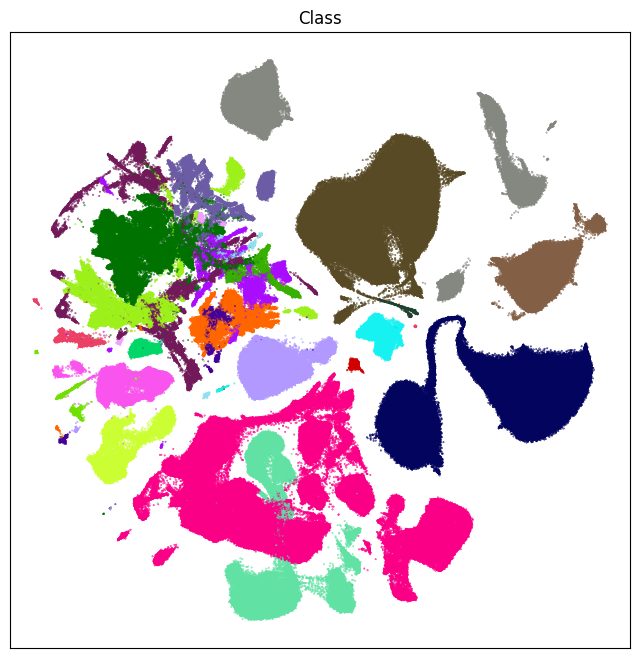

In [24]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['class_color'])
res = ax.set_title("Class")
plt.show()

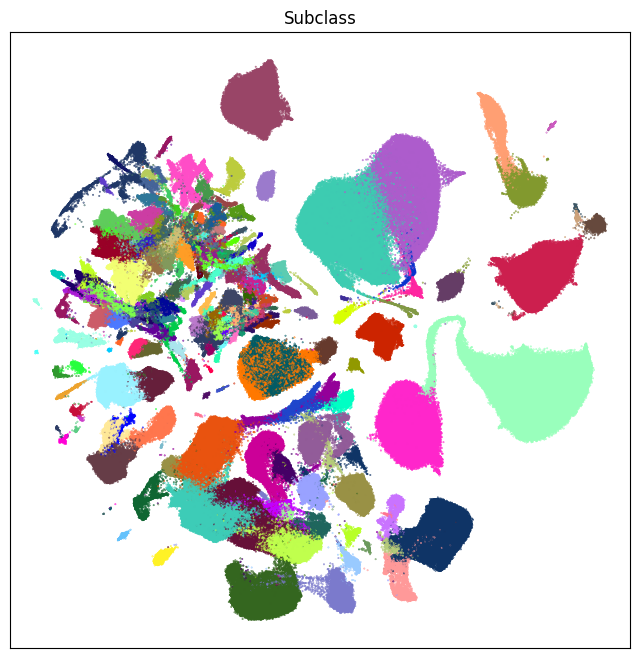

In [25]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['subclass_color'])
res = ax.set_title("Subclass")
plt.show()

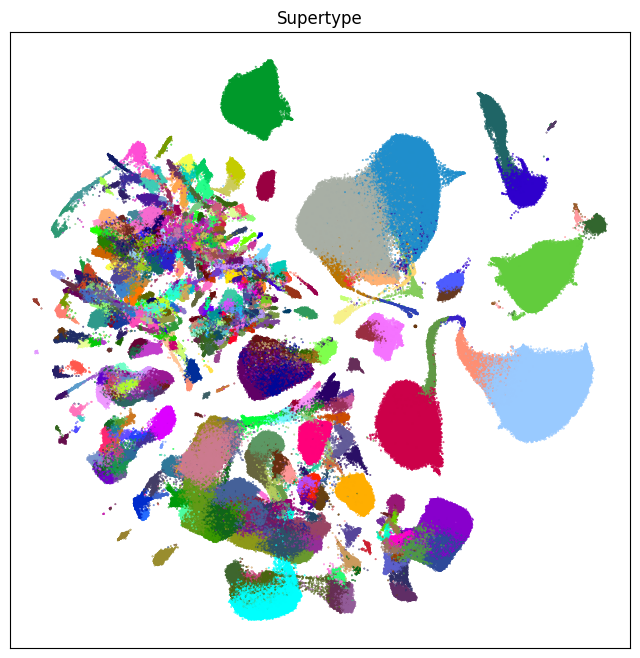

In [26]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['supertype_color'])
res = ax.set_title("Supertype")
plt.show()

### Aggregating cluster and cells counts per term 

Finally in this walkthrough of the data, we'll explore the taxonomy a bit more. 

Now that we have information associated in each cluster and the full hierarchy of the taxonomy loaded, we can merge the cluster_info and cell mapping tables on their index (cluster_alias), producing a dataset describing the taxonomy. We'll use this to display counts of cells and clusters against various metadata. 

We'll need to load one more metadata containing the full mapping of Aging Mouse cluster to the WMB taxonomy. 

In [27]:
cluster_mapping = abc_cache.get_metadata_dataframe(
    directory='Zeng-Aging-Mouse-WMB-taxonomy',
    file_name='cluster_mapping',
    dtype={'cluster_label': str}
).set_index('cluster_alias')
cluster_mapping.head()

cluster_label  cluster_order               cluster_name  \
cluster_alias                                                              
1              CS20241021_0001              0  1_CLA-EPd-CTX Car3 Glut_1   
2              CS20241021_0002              1         2_IT EP-CLA Glut_1   
3              CS20241021_0003              2         3_IT EP-CLA Glut_1   
4              CS20241021_0004              3         4_IT EP-CLA Glut_1   
5              CS20241021_0005              4         5_IT EP-CLA Glut_1   

              cluster_color cluster_annotation_term_label  \
cluster_alias                                               
1                   #f7c27a          CS20230722_SUPT_0001   
2                   #5c1a34          CS20230722_SUPT_0003   
3                   #b96cf0          CS20230722_SUPT_0003   
4                   #bff691          CS20230722_SUPT_0003   
5                   #39fbfa          CS20230722_SUPT_0003   

               cluster_annotation_term_name cluster_annotation_term_set_label  \
cluster_alias                                                                   
1              0001 CLA-EPd-CTX Car3 Glut_1                  CCN20230722_SUPT   
2                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
3                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
4                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
5                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   

                 parent_term_label parent_term_set_label  term_set_order  \
cluster_alias                                                              
1              CS20230722_SUBC_001      CCN20230722_SUBC               3   
2              CS20230722_SUBC_002      CCN20230722_SUBC               3   
3              CS20230722_SUBC_002      CCN20230722_SUBC               3   
4              CS20230722_SUBC_002      CCN20230722_SUBC               3   
5              CS20230722_SUBC_002      CCN20230722_SUBC               3   

               term_order cluster_annotation_term_set_name color_hex_triplet  
cluster_alias                                                                 
1                       0                        supertype           #99822E  
2                       2                        supertype           #994563  
3                       2                        supertype           #994563  
4                       2                        supertype           #994563  
5                       2                        supertype           #994563

Merge in cluster info to get the full set of colors and neurotransmitter identities.

In [28]:
membership = cluster_mapping.join(cluster_info, rsuffix='_cl_info')
membership.head()

cluster_label  cluster_order               cluster_name  \
cluster_alias                                                              
1              CS20241021_0001              0  1_CLA-EPd-CTX Car3 Glut_1   
2              CS20241021_0002              1         2_IT EP-CLA Glut_1   
3              CS20241021_0003              2         3_IT EP-CLA Glut_1   
4              CS20241021_0004              3         4_IT EP-CLA Glut_1   
5              CS20241021_0005              4         5_IT EP-CLA Glut_1   

              cluster_color cluster_annotation_term_label  \
cluster_alias                                               
1                   #f7c27a          CS20230722_SUPT_0001   
2                   #5c1a34          CS20230722_SUPT_0003   
3                   #b96cf0          CS20230722_SUPT_0003   
4                   #bff691          CS20230722_SUPT_0003   
5                   #39fbfa          CS20230722_SUPT_0003   

               cluster_annotation_term_name cluster_annotation_term_set_label  \
cluster_alias                                                                   
1              0001 CLA-EPd-CTX Car3 Glut_1                  CCN20230722_SUPT   
2                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
3                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
4                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
5                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   

                 parent_term_label parent_term_set_label  term_set_order  ...  \
cluster_alias                                                             ...   
1              CS20230722_SUBC_001      CCN20230722_SUBC               3  ...   
2              CS20230722_SUBC_002      CCN20230722_SUBC               3  ...   
3              CS20230722_SUBC_002      CCN20230722_SUBC               3  ...   
4              CS20230722_SUBC_002      CCN20230722_SUBC               3  ...   
5              CS20230722_SUBC_002      CCN20230722_SUBC               3  ...   

               proportion_adult_cells proportion_aged_cells odds_ratio  \
cluster_alias                                                            
1                            0.215041              0.784959   1.453797   
2                            0.484848              0.515152   0.421595   
3                            0.407470              0.592530   0.576896   
4                            0.516908              0.483092   0.371035   
5                            0.305932              0.694068   0.900735   

               log2_odds_ratio cluster_age_bias  max_region_of_interest_color  \
cluster_alias                                                                   
1                     0.539826       unassigned                       #219866   
2                    -1.246071       unassigned                       #219866   
3                    -0.793616       unassigned                       #219866   
4                    -1.430373       unassigned                       #219866   
5                    -0.150825       unassigned                       #219866   

              cluster_age_bias_color neurotransmitter_combined_label  \
cluster_alias                                                          
1                            #DADEDF                            Glut   
2                            #DADEDF                            Glut   
3                            #DADEDF                            Glut   
4                            #DADEDF                            Glut   
5                            #DADEDF                            Glut   

              neurotransmitter_label  neurotransmitter_color  
cluster_alias                                                 
1                               Glut                 #2B93DF  
2                               Glut                 #2B93DF  
3                               Glut                 #2B93DF  
4            

One final set of data to create is to calculate the number of clusters that are members of a given supertype, subclass, and class in the taxonomy.

In [29]:
# Count the number of clusters associated with each cluster annotation term
term_cluster_count = membership.groupby(['cluster_annotation_term_label'])[['cluster_label']].count()
term_cluster_count.columns = ['number_of_clusters']
term_cluster_count.head()

number_of_clusters
cluster_annotation_term_label                    
CS20230722_CLAS_01                            156
CS20230722_CLAS_02                             38
CS20230722_CLAS_03                              1
CS20230722_CLAS_04                              6
CS20230722_CLAS_05                              4

In [30]:
term_by_label = membership.set_index('cluster_annotation_term_label')
term_with_counts = term_by_label.join(term_cluster_count)
term_with_counts.head()

cluster_label  cluster_order  \
cluster_annotation_term_label                                   
CS20230722_SUPT_0001           CS20241021_0001              0   
CS20230722_SUPT_0003           CS20241021_0002              1   
CS20230722_SUPT_0003           CS20241021_0003              2   
CS20230722_SUPT_0003           CS20241021_0004              3   
CS20230722_SUPT_0003           CS20241021_0005              4   

                                            cluster_name cluster_color  \
cluster_annotation_term_label                                            
CS20230722_SUPT_0001           1_CLA-EPd-CTX Car3 Glut_1       #f7c27a   
CS20230722_SUPT_0003                  2_IT EP-CLA Glut_1       #5c1a34   
CS20230722_SUPT_0003                  3_IT EP-CLA Glut_1       #b96cf0   
CS20230722_SUPT_0003                  4_IT EP-CLA Glut_1       #bff691   
CS20230722_SUPT_0003                  5_IT EP-CLA Glut_1       #39fbfa   

                               cluster_annotation_term_name  \
cluster_annotation_term_label                                 
CS20230722_SUPT_0001           0001 CLA-EPd-CTX Car3 Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20230722_SUPT_0001                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   

                                 parent_term_label parent_term_set_label  \
cluster_annotation_term_label                                              
CS20230722_SUPT_0001           CS20230722_SUBC_001      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   

                               term_set_order  term_order  ...  \
cluster_annotation_term_label                              ...   
CS20230722_SUPT_0001                        3           0  ...   
CS20230722_SUPT_0003                        3           2  ...   
CS20230722_SUPT_0003                        3           2  ...   
CS20230722_SUPT_0003                        3           2  ...   
CS20230722_SUPT_0003                        3           2  ...   

                              proportion_aged_cells odds_ratio  \
cluster_annotation_term_label                                    
CS20230722_SUPT_0001                       0.784959   1.453797   
CS20230722_SUPT_0003                       0.515152   0.421595   
CS20230722_SUPT_0003                       0.592530   0.576896   
CS20230722_SUPT_0003                       0.483092   0.371035   
CS20230722_SUPT_0003                       0.694068   0.900735   

                               log2_odds_ratio cluster_age_bias  \
cluster_annotation_term_label                                     
CS20230722_SUPT_0001                  0.539826       unassigned   
CS20230722_SUPT_0003                 -1.246071       unassigned   
CS20230722_SUPT_0003                 -0.793616       unassigned   
CS20230722_SUPT_0003                 -1.430373       unassigned   
CS20230722_SUPT_0003                 -0.150825       unassigned   

                               max_region_of_interest_color  \
cluster_annotation_term_label                                 
CS20230722_SUPT_0001                                #219866   
CS20230722_SUPT_0003        

Let's visualize cluster and cells counts for of the classification levels using bar plots.

In [31]:
def bar_plot_by_level_and_type(df, level=None, fig_width = 8.5, fig_height = 4):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for idx, ctype in enumerate(['clusters', 'cells']):

        if level.lower().startswith('neurotransmitter'):
            level = 'Neurotransmitter'
            names = df['neurotransmitter_label']
            pred = np.ones(len(df), dtype=bool)
            colors = df['neurotransmitter_color']
            counts = df['number_of_%s' % ctype]
        else:
            pred = (df['cluster_annotation_term_set_name'] == level)
            names = df[pred]['cluster_annotation_term_name']
            colors = df[pred]['color_hex_triplet']
            counts = df[pred]['number_of_%s' % ctype]
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype, level)),
        ax[idx].set_xscale('log')

        if idx > 0 :
            ax[idx].set_yticklabels([])

    plt.show()

#### Neurotransmitter cluster and cell counts  

As seen below, most of the clusters in the study are glutamatergic, while the majority of cells are Nonneuronal. 

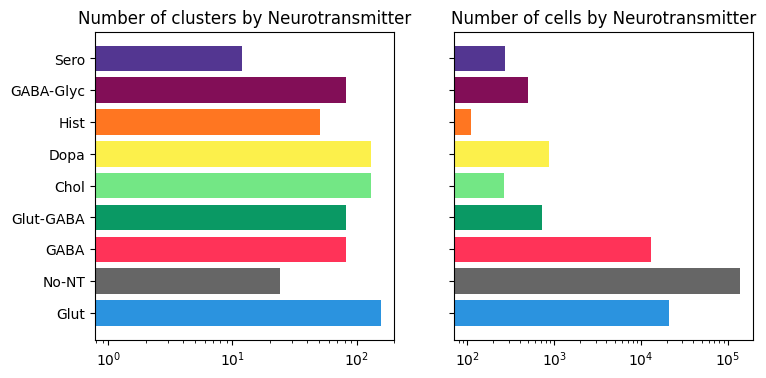

In [32]:
bar_plot_by_level_and_type(term_with_counts, 'neurotransmitter_label')

#### Class level cluster and cell counts 

Class "01 IT-ET" contains the largest number of clusters (~100), while class "30 Astro-Epen" contains the largest number of cells. 

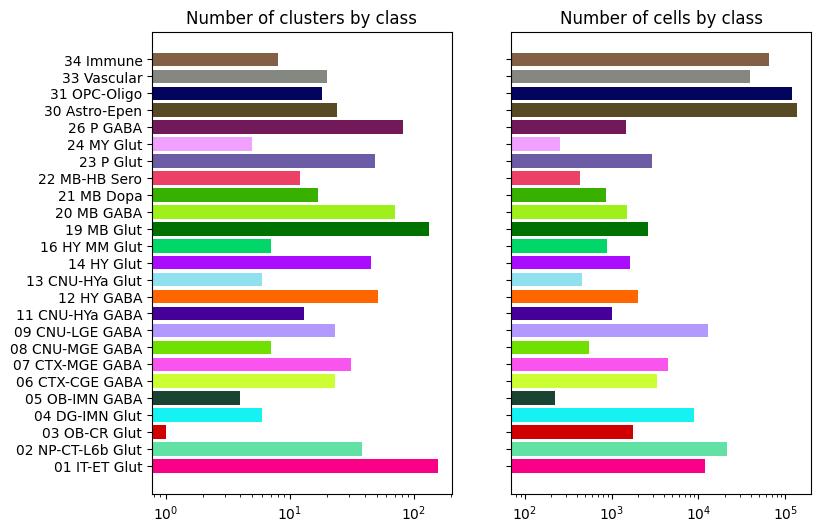

In [33]:
bar_plot_by_level_and_type(term_with_counts, 'class', 8.5, 6)

### Visualizing cluster and term distributions 

We can explore the relationship and distribution of clusters between term sets by creating a pivot table using pandas groupby function. Each row of the resulting DataFrame represents a cluster, each column represents a term set and the value in the table is the name of the term that has been associated with the cluster for that specific term set. 

In [34]:
pivot = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['cluster_annotation_term_name'].first().unstack()
pivot = pivot.join(cluster_info)
pivot.head()

class                   subclass  \
cluster_alias                                             
1              01 IT-ET Glut  001 CLA-EPd-CTX Car3 Glut   
2              01 IT-ET Glut         002 IT EP-CLA Glut   
3              01 IT-ET Glut         002 IT EP-CLA Glut   
4              01 IT-ET Glut         002 IT EP-CLA Glut   
5              01 IT-ET Glut         002 IT EP-CLA Glut   

                                  supertype  number_of_cells    cluster_label  \
cluster_alias                                                                   
1              0001 CLA-EPd-CTX Car3 Glut_1              851  CS20241021_0001   
2                     0003 IT EP-CLA Glut_1              330  CS20241021_0002   
3                     0003 IT EP-CLA Glut_1              589  CS20241021_0003   
4                     0003 IT EP-CLA Glut_1              207  CS20241021_0004   
5                     0003 IT EP-CLA Glut_1             2141  CS20241021_0005   

               cluster_order               cluster_name cluster_color  \
cluster_alias                                                           
1                          0  1_CLA-EPd-CTX Car3 Glut_1       #f7c27a   
2                          1         2_IT EP-CLA Glut_1       #5c1a34   
3                          2         3_IT EP-CLA Glut_1       #b96cf0   
4                          3         4_IT EP-CLA Glut_1       #bff691   
5                          4         5_IT EP-CLA Glut_1       #39fbfa   

              max_region_of_interest_label  \
cluster_alias                                
1                          Isocortex  - AI   
2                          Isocortex  - AI   
3                          Isocortex  - AI   
4                          Isocortex  - AI   
5                          Isocortex  - AI   

               proportion_max_region_of_interest_label  ...  \
cluster_alias                                           ...   
1                                             0.831962  ...   
2                                             0.969697  ...   
3                                             0.894737  ...   
4                                             0.971014  ...   
5                                             0.987389  ...   

               proportion_adult_cells  proportion_aged_cells  odds_ratio  \
cluster_alias                                                              
1                            0.215041               0.784959    1.453797   
2                            0.484848               0.515152    0.421595   
3                            0.407470               0.592530    0.576896   
4                            0.516908               0.483092    0.371035   
5                            0.305932               0.694068    0.900735   

               log2_odds_ratio  cluster_age_bias  \
cluster_alias                                      
1                     0.539826        unassigned   
2                    -1.246071        unassigned   
3                    -0.793616        unassigned   
4                    -1.430373        unassigned   
5                    -0.150825        unassigned   

               max_region_of_interest_color cluster_age_bias_color  \
cluster_alias                                                        
1                                   #219866                #DADEDF   
2                                   #219866                #DADEDF   
3                                   #219866                #DADEDF   
4                                   #219866                #DADEDF   
5                                   #219866                #DADEDF   

              neurotransmitter_combined_label neurotransmitter_label  \
cluster_alias                                                          
1                                        Glut                   Glut   
2                                        Glut                   Glut   
3                                        Glut                   Glut   
4              

We can also obtain a cluster annotation color pivot table in the same way.

In [35]:
color = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['color_hex_triplet'].first().unstack().fillna('#f9f9f9')
color.columns = ['%s_color' % x for x in color.columns]
color.head()

class_color subclass_color supertype_color
cluster_alias                                           
1                 #FA0087        #64c2fc         #99822E
2                 #FA0087        #1F665D         #994563
3                 #FA0087        #1F665D         #994563
4                 #FA0087        #1F665D         #994563
5                 #FA0087        #1F665D         #994563

In [36]:
pivot = pivot.join(color)

### Plotting distributions of clusters and cells by taxonomy level

For a given pair of term sets A and B, we compute a cluster count table where the rows are terms in term set A, columns are terms in term set B with the table values being the number of clusters that are shared between the terms. 

In [37]:
def distribution(A, B, B_color) :
    
    AxB = pivot.groupby([A, B])[['cluster_name']].count()
    AxB.columns = ['number_of_clusters']
    AxB = AxB.unstack().fillna(0)
    B_names = pivot[B].unique()
    B_colors = pd.Series(data=pivot[B_color].unique(), index=B_names)
    
    return AxB, B_names, B_colors

Function *stacked_bar_distribution* takes the results of *distribution* as input to create distribution stacked bar plot.


In [38]:
def stacked_bar_distribution(AxB, B_names, B_colors, fig_width = 6, fig_height = 6):
    """
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    bottom = np.zeros(len(AxB))

    for i, col in enumerate(AxB.columns):
        ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors.loc[col[1]])
        bottom += np.array(AxB[col])

    ax.set_title('Distribution of %s in each %s' % (AxB.columns.names[1], AxB.index.name))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    return fig, ax

#### Distribution of neurotransmitter clusters in each class

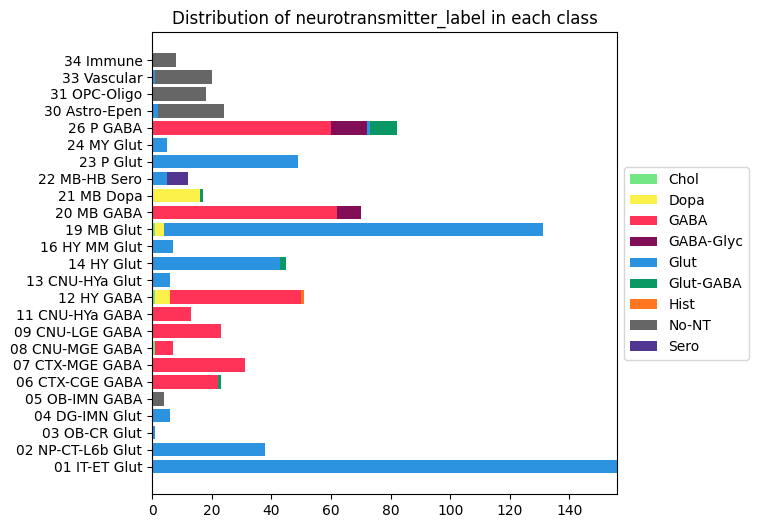

In [39]:
AxB, B_names, B_colors = distribution('class', 'neurotransmitter_label', 'neurotransmitter_color')
fig, ax = stacked_bar_distribution(AxB, B_names, B_colors, 6, 6)

#### Distribution of age enriched vs age depleted clusters

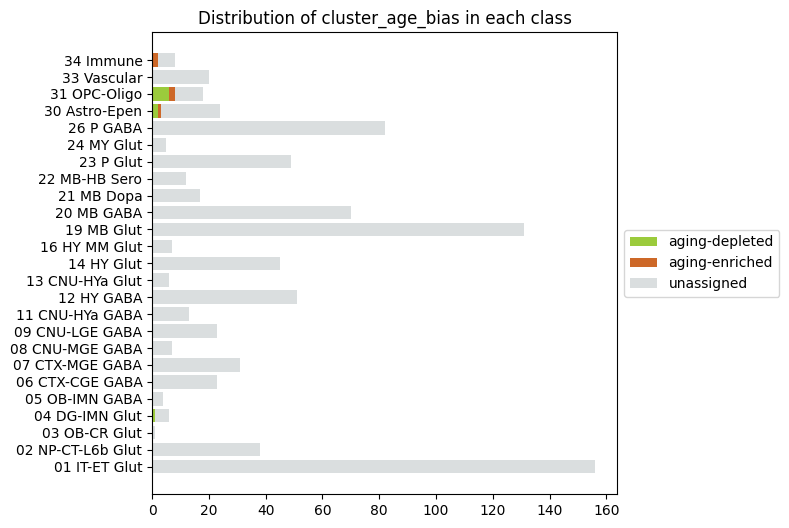

In [40]:
AxB, B_names, B_colors = distribution('class', 'cluster_age_bias', 'cluster_age_bias_color')
fig, ax = stacked_bar_distribution(AxB, B_names, B_colors, 6, 6)

#### Distribution of adult and aged cells

We can use the same groupby functionality as our distribution functions to this time sum up all the adult and age cells in each cluster and plot those versus class (or subclass, supertype). Note that there are ~600k aged cells vs ~400k adult cells in the data so an overall bias towards the aged cells is expected.

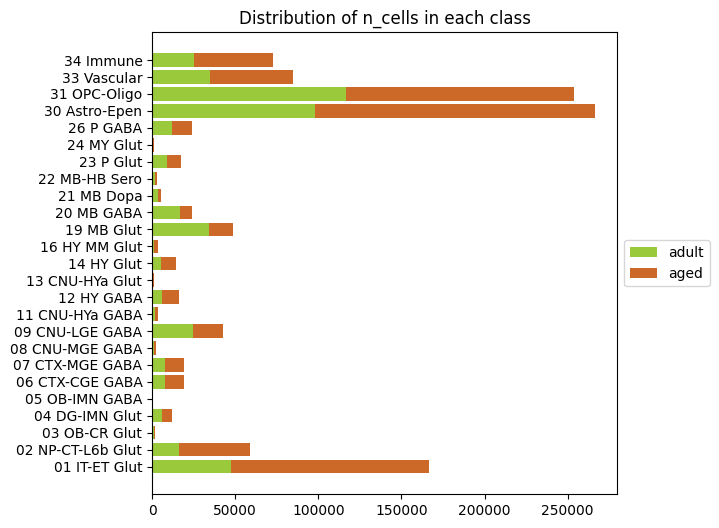

In [41]:
# Sum up the number of aged and adult cells.
n_adult = pivot.groupby(['class'])[['number_of_adult_cells']].sum()
n_aged = pivot.groupby(['class'])[['number_of_aged_cells']].sum()
adult_vs_aged = n_adult.join(n_aged)

# Rename columns and correctly label the aged/adult cells by color.
adult_vs_aged.columns = pd.MultiIndex.from_tuples(
    [('n_cells', 'adult'), ('n_cells', 'aged')],
    names=[None, 'n_cells'])
B_names = ['adult', 'aged']
B_colors = pd.Series(data=['#9ACA3C', '#CC6828'], index=B_names)

# Plot our barplot
fig, ax = stacked_bar_distribution(adult_vs_aged, B_names, B_colors, 6, 6)

### Visualizing the mouse whole brain taxonomy  

Term sets: class, subclass, supertype and cluster form a four-level mouse whole brain taxonomy. We can visualize the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the class level is the outer most ring so that we can add in each class’s labels. Rings are sliced up and divided based on their hierarchical relationship to the parent slice. The angle of each slice is proportional to the number of clusters belonging to the term. 

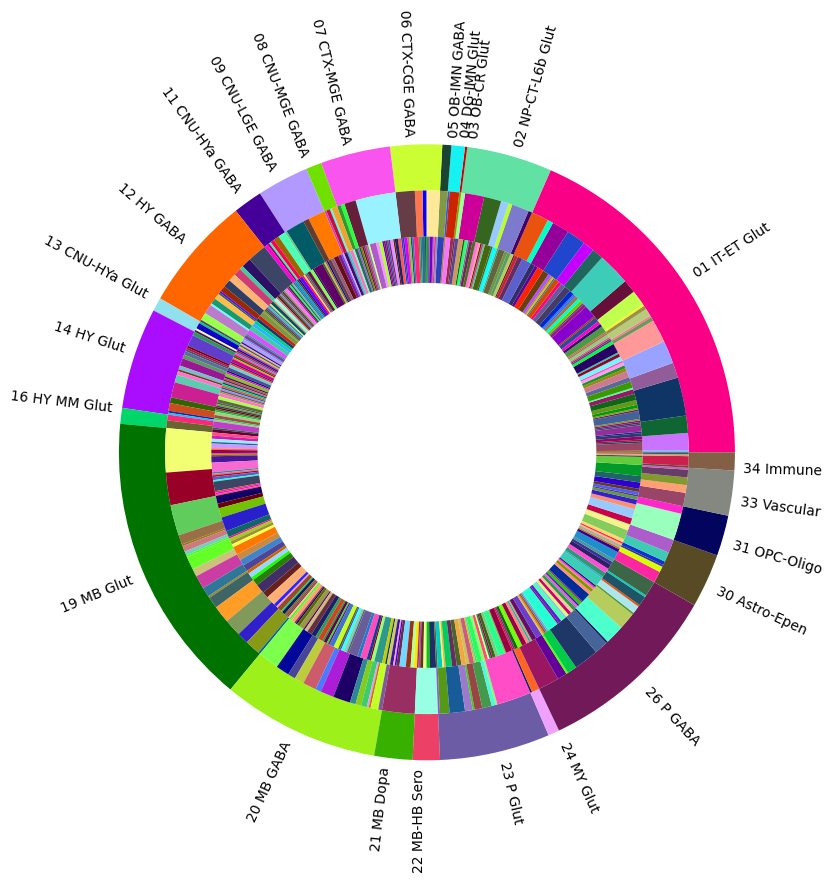

In [42]:
levels = ['class', 'subclass', 'supertype']
df = {}

for lvl in levels:
    pred = term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_term_label'])
    df[lvl] = df[lvl][~df[lvl].index.duplicated(keep='first')]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'class':
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               labels=df[lvl]['cluster_annotation_term_name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else:
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)

plt.show()

**In part 2 we'll focus on gene data including using the UMAP to plot gene expression locations as well as age Differential (ageDE) genes identified in Zeng et al.**